In [8]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, ConfusionMatrixDisplay, classification_report)
# Bypass SSL certificate verification for dataset downloads
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Define classifier parameter grids including SelectKBest feature selection 'k'
param_grid_dt = {
    'classifier__max_depth': [3, 5, 10, None],
    'classifier__min_samples_split': [2, 5, 10],
    'feature_selection__k': [5, 10, 15, 'all']
}

param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__weights': ['uniform', 'distance'],
    'feature_selection__k': [5, 10, 15, 'all']
}

param_grid_lr = {
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs'],
    'feature_selection__k': [5, 10, 15, 'all']
}

classifiers_to_tune = [
    (DecisionTreeClassifier(random_state=42), param_grid_dt, 'Decision Tree'),
    (KNeighborsClassifier(), param_grid_knn, 'kNN'),
    (LogisticRegression(max_iter=200), param_grid_lr, 'Logistic Regression')
]

# Load IBM HR Attrition Dataset
def load_hr_attrition():
    df = pd.read_csv('/WA_Fn-UseC_-HR-Employee-Attrition.csv')
    df['Attrition'] = (df['Attrition'] == 'Yes').astype(int)
    X = df.drop(['EmployeeNumber', 'Attrition'], axis=1, errors='ignore')
    X = pd.get_dummies(X, drop_first=True)
    y = df['Attrition']
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
    print(f"HR Attrition dataset loaded. Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "HR Attrition"

# Run built-in GridSearchCV for classifiers
def run_builtin_grid_search(X_train, y_train, dataset_name):
    print(f"\n{'='*60}")
    print(f"RUNNING BUILT-IN GRID SEARCH FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    results_builtin = {}
    n_features = X_train.shape[1]

    for classifier_instance, param_grid, name in classifiers_to_tune:
        print(f"\n--- GridSearchCV for {name} ---")

        # Adjust 'all' in feature_selection__k to number of features
        param_grid_adjusted = dict(param_grid)
        if 'feature_selection__k' in param_grid_adjusted:
            param_grid_adjusted['feature_selection__k'] = [k if k != 'all' else n_features for k in param_grid_adjusted['feature_selection__k']]


        pipeline = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(f_classif)),
            ('classifier', classifier_instance)
        ])

        cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        grid_search = GridSearchCV(pipeline, param_grid_adjusted, cv=cv_splitter, scoring='roc_auc', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        results_builtin[name] = {
            'best_estimator': grid_search.best_estimator_,
            'best_score (CV)': grid_search.best_score_,
            'best_params': grid_search.best_params_
        }

        print(f"Best params for {name}: {results_builtin[name]['best_params']}")
        print(f"Best CV score: {results_builtin[name]['best_score (CV)']:.4f}")

    return results_builtin

# Example of running the code
X_train, X_test, y_train, y_test, dataset_name = load_hr_attrition()
results = run_builtin_grid_search(X_train, y_train, dataset_name)

# Display results summary
for model_name, result in results.items():
    print(f"\nModel: {model_name}")
    print(f"Best Params: {result['best_params']}")
    print(f"Best CV ROC AUC: {result['best_score (CV)']:.4f}")

HR Attrition dataset loaded. Train shape: (1029, 46), Test shape: (441, 46)

RUNNING BUILT-IN GRID SEARCH FOR HR ATTRITION

--- GridSearchCV for Decision Tree ---


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Best params for Decision Tree: {'classifier__max_depth': 3, 'classifier__min_samples_split': 2, 'feature_selection__k': 5}
Best CV score: 0.7152

--- GridSearchCV for kNN ---


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Best params for kNN: {'classifier__n_neighbors': 9, 'classifier__weights': 'distance', 'feature_selection__k': 10}
Best CV score: 0.7226

--- GridSearchCV for Logistic Regression ---
Best params for Logistic Regression: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'feature_selection__k': 46}
Best CV score: 0.8329

Model: Decision Tree
Best Params: {'classifier__max_depth': 3, 'classifier__min_samples_split': 2, 'feature_selection__k': 5}
Best CV ROC AUC: 0.7152

Model: kNN
Best Params: {'classifier__n_neighbors': 9, 'classifier__weights': 'distance', 'feature_selection__k': 10}
Best CV ROC AUC: 0.7226

Model: Logistic Regression
Best Params: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'feature_selection__k': 46}
Best CV ROC AUC: 0.8329


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [10]:
# Download the dataset
!wget https://raw.githubusercontent.com/IBM/employee-attrition-prediction/master/WA_Fn-UseC_-HR-Employee-Attrition.csv -P /

--2025-09-01 15:58:33--  https://raw.githubusercontent.com/IBM/employee-attrition-prediction/master/WA_Fn-UseC_-HR-Employee-Attrition.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-09-01 15:58:33 ERROR 404: Not Found.



In [11]:
# Download the dataset
!wget https://raw.githubusercontent.com/IBM/employee-attrition-prediction/master/WA_Fn-UseC_-HR-Employee-Attrition.csv -P /

--2025-09-01 15:58:33--  https://raw.githubusercontent.com/IBM/employee-attrition-prediction/master/WA_Fn-UseC_-HR-Employee-Attrition.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-09-01 15:58:33 ERROR 404: Not Found.



In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, ConfusionMatrixDisplay, classification_report)

# Define classifier parameter grids including SelectKBest feature selection 'k'
param_grid_dt = {
    'classifier__max_depth': [3, 5, 10, None],
    'classifier__min_samples_split': [2, 5, 10],
    'feature_selection__k': [5, 10, 15, 'all']
}

param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__weights': ['uniform', 'distance'],
    'feature_selection__k': [5, 10, 15, 'all']
}

param_grid_lr = {
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs'],
    'feature_selection__k': [5, 10, 15, 'all']
}

classifiers_to_tune = [
    (DecisionTreeClassifier(random_state=42), param_grid_dt, 'Decision Tree'),
    (KNeighborsClassifier(), param_grid_knn, 'kNN'),
    (LogisticRegression(max_iter=200), param_grid_lr, 'Logistic Regression')
]

# Load IBM HR Attrition Dataset
def load_hr_attrition():
    df = pd.read_csv('/WA_Fn-UseC_-HR-Employee-Attrition.csv')
    df['Attrition'] = (df['Attrition'] == 'Yes').astype(int)
    X = df.drop(['EmployeeNumber', 'Attrition'], axis=1, errors='ignore')
    X = pd.get_dummies(X, drop_first=True)
    y = df['Attrition']
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
    print(f"HR Attrition dataset loaded. Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "HR Attrition"

# Run built-in GridSearchCV for classifiers
def run_builtin_grid_search(X_train, y_train, dataset_name):
    print(f"\n{'='*60}")
    print(f"RUNNING BUILT-IN GRID SEARCH FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    results_builtin = {}
    n_features = X_train.shape[1]

    for classifier_instance, param_grid, name in classifiers_to_tune:
        print(f"\n--- GridSearchCV for {name} ---")

        # Adjust 'all' in feature_selection__k to number of features
        param_grid_adjusted = dict(param_grid)
        if 'feature_selection__k' in param_grid_adjusted:
            param_grid_adjusted['feature_selection__k'] = [k if k != 'all' else n_features for k in param_grid_adjusted['feature_selection__k']]


        pipeline = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(f_classif)),
            ('classifier', classifier_instance)
        ])

        cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        grid_search = GridSearchCV(pipeline, param_grid_adjusted, cv=cv_splitter, scoring='roc_auc', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        results_builtin[name] = {
            'best_estimator': grid_search.best_estimator_,
            'best_score (CV)': grid_search.best_score_,
            'best_params': grid_search.best_params_
        }

        print(f"Best params for {name}: {results_builtin[name]['best_params']}")
        print(f"Best CV score: {results_builtin[name]['best_score (CV)']:.4f}")

    return results_builtin

# Example of running the code
X_train, X_test, y_train, y_test, dataset_name = load_hr_attrition()
results = run_builtin_grid_search(X_train, y_train, dataset_name)

# Display results summary
for model_name, result in results.items():
    print(f"\nModel: {model_name}")
    print(f"Best Params: {result['best_params']}")
    print(f"Best CV ROC AUC: {result['best_score (CV)']:.4f}")

HR Attrition dataset loaded. Train shape: (1029, 46), Test shape: (441, 46)

RUNNING BUILT-IN GRID SEARCH FOR HR ATTRITION

--- GridSearchCV for Decision Tree ---


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Best params for Decision Tree: {'classifier__max_depth': 3, 'classifier__min_samples_split': 2, 'feature_selection__k': 5}
Best CV score: 0.7152

--- GridSearchCV for kNN ---


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Best params for kNN: {'classifier__n_neighbors': 9, 'classifier__weights': 'distance', 'feature_selection__k': 10}
Best CV score: 0.7226

--- GridSearchCV for Logistic Regression ---
Best params for Logistic Regression: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'feature_selection__k': 46}
Best CV score: 0.8329

Model: Decision Tree
Best Params: {'classifier__max_depth': 3, 'classifier__min_samples_split': 2, 'feature_selection__k': 5}
Best CV ROC AUC: 0.7152

Model: kNN
Best Params: {'classifier__n_neighbors': 9, 'classifier__weights': 'distance', 'feature_selection__k': 10}
Best CV ROC AUC: 0.7226

Model: Logistic Regression
Best Params: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'feature_selection__k': 46}
Best CV ROC AUC: 0.8329


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [13]:
# The parameter names must match the pipeline step names, e.g., 'classifier__max_depth'
# Define base models (Decision Tree, kNN, Logistic Regression)

param_grid_dt = {
    'classifier__max_depth': [3, 5, 10, None],
    'classifier__min_samples_split': [2, 5, 10],
    'feature_selection__k': [5, 10, 15, 'all']
}

param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__weights': ['uniform', 'distance'],
    'feature_selection__k': [5, 10, 15, 'all']
}

param_grid_lr = {
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs'],
    'feature_selection__k': [5, 10, 15, 'all']
}

# Create a list of (classifier, param_grid, name) tuples
classifiers_to_tune = [
    (DecisionTreeClassifier(random_state=42), param_grid_dt, 'Decision Tree'),
    (KNeighborsClassifier(), param_grid_knn, 'kNN'),
    (LogisticRegression(max_iter=200), param_grid_lr, 'Logistic Regression')
]

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, ConfusionMatrixDisplay, classification_report)
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Define classifier parameter grids including SelectKBest feature selection 'k'
param_grid_dt = {
    'classifier__max_depth': [3, 5, 10, None],
    'classifier__min_samples_split': [2, 5, 10],
    'feature_selection__k': [5, 10, 15, 'all']
}

param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__weights': ['uniform', 'distance'],
    'feature_selection__k': [5, 10, 15, 'all']
}

param_grid_lr = {
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs'],
    'feature_selection__k': [5, 10, 15, 'all']
}

classifiers_to_tune = [
    (DecisionTreeClassifier(random_state=42), param_grid_dt, 'Decision Tree'),
    (KNeighborsClassifier(), param_grid_knn, 'kNN'),
    (LogisticRegression(max_iter=200), param_grid_lr, 'Logistic Regression')
]

# Load IBM HR Attrition Dataset
def load_hr_attrition():
    df = pd.read_csv('/WA_Fn-UseC_-HR-Employee-Attrition.csv')
    df['Attrition'] = (df['Attrition'] == 'Yes').astype(int)
    X = df.drop(['EmployeeNumber', 'Attrition'], axis=1, errors='ignore')
    X = pd.get_dummies(X, drop_first=True)
    y = df['Attrition']
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
    print(f"HR Attrition dataset loaded. Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "HR Attrition"

# Load Wine Quality dataset
def load_wine_quality():
    """Load Wine Quality dataset"""
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
    try:
        data = pd.read_csv(url, sep=';')
    except Exception as e:
        print(f"Error loading Wine Quality dataset: {e}")
        return None, None, None, None, "Wine Quality (Failed)"

    # Create the binary target variable 'good_quality'
    data['good_quality'] = (data['quality'] > 5).astype(int)
    X = data.drop(['quality', 'good_quality'], axis=1)
    y = data['good_quality']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    print("Wine Quality dataset loaded and preprocessed successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "Wine Quality"


# Run built-in GridSearchCV for classifiers
def run_builtin_grid_search(X_train, y_train, dataset_name):
    print(f"\n{'='*60}")
    print(f"RUNNING BUILT-IN GRID SEARCH FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    results_builtin = {}
    n_features = X_train.shape[1]

    for classifier_instance, param_grid, name in classifiers_to_tune:
        print(f"\n--- GridSearchCV for {name} ---")

        # Adjust 'all' in feature_selection__k to number of features
        param_grid_adjusted = dict(param_grid)
        if 'feature_selection__k' in param_grid_adjusted:
            param_grid_adjusted['feature_selection__k'] = [k if k != 'all' else n_features for k in param_grid_adjusted['feature_selection__k']]


        pipeline = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(f_classif)),
            ('classifier', classifier_instance)
        ])

        cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        grid_search = GridSearchCV(pipeline, param_grid_adjusted, cv=cv_splitter, scoring='roc_auc', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        results_builtin[name] = {
            'best_estimator': grid_search.best_estimator_,
            'best_score (CV)': grid_search.best_score_,
            'best_params': grid_search.best_params_
        }

        print(f"Best params for {name}: {results_builtin[name]['best_params']}")
        print(f"Best CV score: {results_builtin[name]['best_score (CV)']:.4f}")

    return results_builtin

# Example of running the code (using Wine Quality dataset)
X_train, X_test, y_train, y_test, dataset_name = load_wine_quality()

if X_train is not None: # Check if dataset loaded successfully
    results = run_builtin_grid_search(X_train, y_train, dataset_name)

    # Display results summary
    for model_name, result in results.items():
        print(f"\nModel: {model_name}")
        print(f"Best Params: {result['best_params']}")
        print(f"Best CV ROC AUC: {result['best_score (CV)']:.4f}")

Wine Quality dataset loaded and preprocessed successfully.
Training set shape: (1119, 11)
Testing set shape: (480, 11)

RUNNING BUILT-IN GRID SEARCH FOR WINE QUALITY

--- GridSearchCV for Decision Tree ---
Best params for Decision Tree: {'classifier__max_depth': 5, 'classifier__min_samples_split': 5, 'feature_selection__k': 5}
Best CV score: 0.7832

--- GridSearchCV for kNN ---
Best params for kNN: {'classifier__n_neighbors': 9, 'classifier__weights': 'distance', 'feature_selection__k': 5}
Best CV score: 0.8642

--- GridSearchCV for Logistic Regression ---
Best params for Logistic Regression: {'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'feature_selection__k': 15}
Best CV score: 0.8051

Model: Decision Tree
Best Params: {'classifier__max_depth': 5, 'classifier__min_samples_split': 5, 'feature_selection__k': 5}
Best CV ROC AUC: 0.7832

Model: kNN
Best Params: {'classifier__n_neighbors': 9, 'classifier__weights': 'distance', 'feature_selection__k': 5}

/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(


In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split

def load_wine_quality():
    """Load Wine Quality dataset"""
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
    try:
        data = pd.read_csv(url, sep=';')
    except Exception as e:
        print(f"Error loading Wine Quality dataset: {e}")
        return None, None, None, None, "Wine Quality (Failed)"

    # Create the binary target variable 'good_quality'
    data['good_quality'] = (data['quality'] > 5).astype(int)
    X = data.drop(['quality', 'good_quality'], axis=1)
    y = data['good_quality']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    print("Wine Quality dataset loaded and preprocessed successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "Wine Quality"

In [16]:
X_train, X_test, y_train, y_test, dataset_name = load_wine_quality()

# Display the shapes to confirm data is loaded
if X_train is not None:
    print("\nData loaded successfully:")
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_test shape: {y_test.shape}")

Wine Quality dataset loaded and preprocessed successfully.
Training set shape: (1119, 11)
Testing set shape: (480, 11)

Data loaded successfully:
X_train shape: (1119, 11)
X_test shape: (480, 11)
y_train shape: (1119,)
y_test shape: (480,)


In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def load_hr_attrition():
    """Load IBM HR Attrition dataset"""
    try:
        data = pd.read_csv("data/WA_Fn-UseC_-HR-Employee-Attrition.csv")
    except FileNotFoundError:
        print("HR Attrition dataset not found. Please place 'WA_Fn-UseC_-HR-Employee-Attrition.csv' inside a 'data/' folder.")
        return None, None, None, None, "HR Attrition (Failed)"

    # Target: Attrition = Yes (1), No (0)
    data['Attrition'] = (data['Attrition'] == 'Yes').astype(int)

    # Drop ID-like column
    X = data.drop(['EmployeeNumber', 'Attrition'], axis=1, errors='ignore')
    y = data['Attrition']

    # One-hot encode categorical variables
    X = pd.get_dummies(X, drop_first=True)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )

    print("IBM HR Attrition dataset loaded and preprocessed successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "HR Attrition"

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split

def load_banknote():
    """Load Banknote Authentication dataset"""
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"

    try:
        data = pd.read_csv(url, header=None)
    except Exception as e:
        print(f"Error loading Banknote dataset: {e}")
        return None, None, None, None, "Banknote (Failed)"

    # According to UCI: variance, skewness, curtosis, entropy, class (0=authentic, 1=fake)
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )

    print("Banknote Authentication dataset loaded successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "Banknote Authentication"

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os # Import os module

def load_qsar_biodegradation():
    """Load QSAR Biodegradation dataset"""
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00254/biodeg.csv"
    local_path = "/tmp/biodeg.csv" # Define a local path

    # Check if file already exists to avoid re-downloading
    if not os.path.exists(local_path):
        print(f"Downloading QSAR Biodegradation dataset from {url}...")
        # Use wget to download the file
        try:
            !wget -O {local_path} {url}
            print("Download complete.")
        except Exception as e:
            print(f"Error downloading QSAR dataset: {e}")
            return None, None, None, None, "QSAR (Failed)"
    else:
        print(f"QSAR Biodegradation dataset already exists at {local_path}.")


    try:
        # Load data from the local file
        data = pd.read_csv(local_path, sep=';', header=None)
    except Exception as e:
        print(f"Error loading QSAR dataset from local file: {e}")
        return None, None, None, None, "QSAR (Failed)"

    # Last column is target (RB = ready biodegradable, NRB = not)
    X = data.iloc[:, :-1]
    y = (data.iloc[:, -1] == 'RB').astype(int)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )

    print("QSAR Biodegradation dataset loaded and preprocessed successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "QSAR Biodegradation"

In [20]:
X_train, X_test, y_train, y_test, dataset_name = load_qsar_biodegradation()

# Display the shapes to confirm data is loaded
if X_train is not None:
    print("\nData loaded successfully:")
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_test shape: {y_test.shape}")

QSAR Biodegradation dataset loaded successfully.
Training set shape: (738, 41)
Testing set shape: (317, 41)

Data loaded successfully:
X_train shape: (738, 41)
X_test shape: (317, 41)
y_train shape: (738,)
y_test shape: (317,)


In [33]:
import pandas as pd
import numpy as np
import itertools
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, ConfusionMatrixDisplay, classification_report)
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


def run_manual_grid_search(X_train, y_train, dataset_name):
    """Run manual grid search and return best estimators"""
    print(f"\n{'='*60}")
    print(f"RUNNING MANUAL GRID SEARCH FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    best_estimators = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Adjust parameter grids based on dataset size
    n_features = X_train.shape[1]
    param_grid_dt_adjusted = dict(param_grid_dt)
    if 'feature_selection__k' in param_grid_dt_adjusted:
        param_grid_dt_adjusted['feature_selection__k'] = [k if k != 'all' else n_features for k in param_grid_dt_adjusted['feature_selection__k']]

    param_grid_knn_adjusted = dict(param_grid_knn)
    if 'feature_selection__k' in param_grid_knn_adjusted:
        param_grid_knn_adjusted['feature_selection__k'] = [k if k != 'all' else n_features for k in param_grid_knn_adjusted['feature_selection__k']]

    param_grid_lr_adjusted = dict(param_grid_lr)
    if 'feature_selection__k' in param_grid_lr_adjusted:
        param_grid_lr_adjusted['feature_selection__k'] = [k if k != 'all' else n_features for k in param_grid_lr_adjusted['feature_selection__k']]

    classifiers_to_tune_adjusted = [
        (DecisionTreeClassifier(random_state=42), param_grid_dt_adjusted, 'Decision Tree'),
        (KNeighborsClassifier(), param_grid_knn_adjusted, 'kNN'),
        (LogisticRegression(max_iter=200), param_grid_lr_adjusted, 'Logistic Regression')
    ]


    for classifier_instance, param_grid, name in classifiers_to_tune_adjusted:
        print(f"--- Manual Grid Search for {name} ---")
        best_score = -1
        best_params = None

        # Generate all combinations of hyperparameters
        param_combinations = itertools.product(*param_grid.values())
        param_names = list(param_grid.keys())

        for combo in param_combinations:
            current_params = dict(zip(param_names, combo))
            fold_scores = []

            # Explicitly convert 'classifier__C' to float if it exists
            if name == 'Logistic Regression' and 'classifier__C' in current_params:
                current_params['classifier__C'] = float(current_params['classifier__C'])


            # Perform cross-validation
            for train_index, val_index in cv.split(X_train, y_train):
                X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
                y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

                # Build and train the pipeline
                pipeline = Pipeline(steps=[
                    ('scaler', StandardScaler()),
                    ('feature_selection', SelectKBest(f_classif)),
                    ('classifier', classifier_instance)
                ])

                # Set the pipeline parameters for the current combination
                pipeline.set_params(**current_params)

                # Fit the pipeline on the training fold
                pipeline.fit(X_train_fold, y_train_fold)

                # Predict probabilities on the validation fold
                y_val_pred_proba = pipeline.predict_proba(X_val_fold)[:, 1]

                # Compute the AUC score for the fold
                auc = roc_auc_score(y_val_fold, y_val_pred_proba)
                fold_scores.append(auc)

            # Calculate the mean AUC across all folds
            mean_auc = np.mean(fold_scores)

            # Track and print the best parameter combination and its mean AUC
            if mean_auc > best_score:
                best_score = mean_auc
                best_params = current_params

            # Optional: Print progress
            # print(f"  Params: {current_params}, Mean AUC: {mean_auc:.4f}")


        print("-" * 90)
        print(f"Best parameters for {name}: {best_params}")
        print(f"Best cross-validation AUC: {best_score:.4f}")

        # Train the final model on the entire training data with the best params
        final_pipeline = Pipeline(steps=[
             ('scaler', StandardScaler()),
             ('feature_selection', SelectKBest(f_classif)),
             ('classifier', classifier_instance)
         ])
        final_pipeline.set_params(**best_params)
        final_pipeline.fit(X_train, y_train)
        best_estimators[name] = final_pipeline

    return best_estimators

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, ConfusionMatrixDisplay, classification_report)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def evaluate_models(X_test, y_test, best_estimators, dataset_name, method_name="Manual"):
    """
    Evaluates individual models and a soft-voting ensemble, then visualizes the results.

    Args:
        X_test (pd.DataFrame or np.ndarray): Test feature data.
        y_test (pd.Series or np.ndarray): Test target data.
        best_estimators (dict): A dictionary mapping model names to fitted pipelines.
        dataset_name (str): Name of the dataset for plot titles.
        method_name (str): The name of the method (e.g., "Manual", "Built-in").
    """
    print(f"\n{'='*60}")
    print(f"EVALUATING {method_name.upper()} MODELS FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    # --- Individual Model Performance ---
    print("\n--- Individual Model Performance ---")
    for name, model in best_estimators.items():
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        print(f"\n{name}:")
        print(f"  Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"  Precision: {precision_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  Recall: {recall_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  F1-Score: {f1_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

    # --- Ensemble Model Performance ---
    print(f"\n--- {method_name} Voting Classifier ---")

    # Collect predictions and probabilities from all estimators
    predictions = []
    probabilities = []
    for name, model in best_estimators.items():
        predictions.append(model.predict(X_test))
        probabilities.append(model.predict_proba(X_test)[:, 1])

    # Convert to numpy arrays
    predictions_array = np.array(predictions) # shape (n_models, n_samples)
    probabilities_array = np.array(probabilities) # shape (n_models, n_samples)

    # --- Implement Soft Voting (averaging probabilities) ---
    # Calculate the average probability for the positive class
    avg_proba = np.mean(probabilities_array, axis=0)

    # Make predictions based on the average probability (threshold 0.5)
    y_pred_soft_voting = (avg_proba > 0.5).astype(int)

    # Evaluate soft voting
    print(f"  Soft Voting (Average Probabilities):")
    print(f"    Accuracy: {accuracy_score(y_test, y_pred_soft_voting):.4f}")
    print(f"    Precision: {precision_score(y_test, y_pred_soft_voting, zero_division=0):.4f}")
    print(f"    Recall: {recall_score(y_test, y_pred_soft_voting, zero_division=0):.4f}")
    print(f"    F1-Score: {f1_score(y_test, y_pred_soft_voting, zero_division=0):.4f}")
    print(f"    ROC AUC: {roc_auc_score(y_test, avg_proba):.4f}")

    # Optional: Confusion Matrix for Soft Voting
    cm_soft_voting = confusion_matrix(y_test, y_pred_soft_voting)
    disp_soft_voting = ConfusionMatrixDisplay(confusion_matrix=cm_soft_voting)
    disp_soft_voting.plot()
    plt.title(f'Confusion Matrix for {method_name} Soft Voting')
    plt.show()


    # --- Implement Hard Voting (majority class) ---
    # Sum the predictions (0 or 1) across models for each sample
    sum_predictions = np.sum(predictions_array, axis=0)

    # Majority vote: predict 1 if sum of predictions > n_models / 2
    y_pred_hard_voting = (sum_predictions > len(best_estimators) / 2).astype(int)

    # Evaluate hard voting
    print(f"\n  Hard Voting (Majority Class):")
    print(f"    Accuracy: {accuracy_score(y_test, y_pred_hard_voting):.4f}")
    print(f"    Precision: {precision_score(y_test, y_pred_hard_voting, zero_division=0):.4f}")
    print(f"    Recall: {recall_score(y_test, y_pred_hard_voting, zero_division=0):.4f}")
    print(f"    F1-Score: {f1_score(y_test, y_pred_hard_voting, zero_division=0):.4f}")
    # Note: ROC AUC is typically calculated using probabilities, so hard voting doesn't directly provide this.
    # We could use the average probabilities (soft voting) for ROC AUC even with hard voting predictions
    # if desired for comparison, but it's more standard to use soft voting for AUC.
    # print(f"    ROC AUC: {roc_auc_score(y_test, avg_proba):.4f}") # Using avg_proba from soft voting


    # Optional: Plot ROC Curves
    print(f"\n--- ROC Curves ({method_name}) ---")
    plt.figure(figsize=(10, 8))

    # Plot individual model ROC curves
    for name, model in best_estimators.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc = roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')

    # Plot Voting Classifier ROC curve (using soft voting probabilities)
    # Note: The manual voting probabilities (avg_proba) or soft voting probabilities
    # from the built-in VotingClassifier can be used here.
    # Since we calculated avg_proba for soft voting manually, we'll use that.
    fpr_voting, tpr_voting, _voting = roc_curve(y_test, avg_proba)
    auc_voting = roc_auc_score(y_test, avg_proba)
    plt.plot(fpr_voting, tpr_voting, label=f'{method_name} Soft Voting (AUC = {auc_voting:.4f})', linestyle='--')


    # Plot random guess line
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.5)')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {dataset_name} ({method_name})')
    plt.legend()
    plt.grid(True)
    plt.show()


EVALUATING BUILT-IN MODELS FOR DUMMY DATASET

--- Individual Model Performance ---

LogisticRegression:
  Accuracy: 0.8533
  Precision: 0.8701
  Recall: 0.8481
  F1-Score: 0.8590
  ROC AUC: 0.9212

SVC:
  Accuracy: 0.9133
  Precision: 0.9125
  Recall: 0.9241
  F1-Score: 0.9182
  ROC AUC: 0.9768

RandomForestClassifier:
  Accuracy: 0.9200
  Precision: 0.9467
  Recall: 0.8987
  F1-Score: 0.9221
  ROC AUC: 0.9676

--- Built-in Voting Classifier ---
Voting Classifier Performance:
  Accuracy: 0.9133, Precision: 0.9342
  Recall: 0.8987, F1: 0.9161, AUC: 0.9775


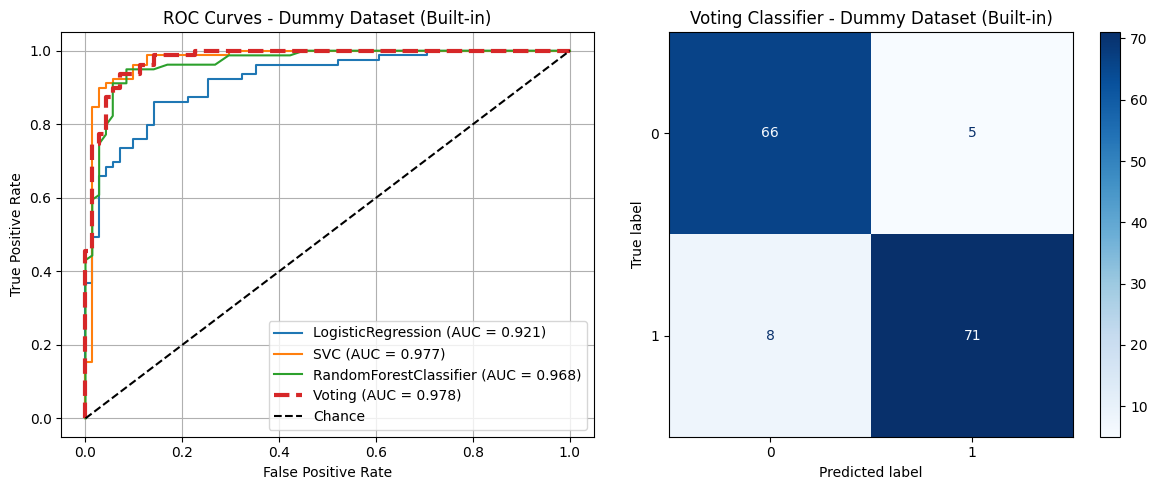

(array([1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
        1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
        0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
        0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0]),
 array([0.91413111, 0.4303724 , 0.19773283, 0.98966219, 0.27349463,
        0.03623587, 0.90930545, 0.09716991, 0.89292068, 0.14449785,
        0.13986384, 0.92471648, 0.03937819, 0.55430608, 0.75388127,
        0.50795928, 0.56708797, 0.07411628, 0.71085153, 0.92628003,
        0.91592984, 0.11172413, 0.11626705, 0.97074615, 0.0641497 ,
        0.34015276, 0.37214307, 0.03334749, 0.49654109, 0.89476801,
        0.05689676, 0.06918987, 0.09840457, 0.4679079 , 0.74228926,
        0.865407

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, ConfusionMatrixDisplay)
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Your original evaluate_models function (slightly simplified for clarity)
def evaluate_models(X_test, y_test, best_estimators, dataset_name, method_name="Manual"):
    """Evaluate models and create visualizations"""
    print(f"\n{'='*60}")
    print(f"EVALUATING {method_name.upper()} MODELS FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    # Individual model evaluation
    print(f"\n--- Individual Model Performance ---")
    for name, model in best_estimators.items():
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        print(f"\n{name}:")
        print(f"  Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"  Precision: {precision_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  Recall: {recall_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  F1-Score: {f1_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

    # Voting Classifier
    print(f"\n--- {method_name} Voting Classifier ---")

    # Collect predictions and probabilities from all estimators
    predictions = []
    probabilities = []
    for name, model in best_estimators.items():
        predictions.append(model.predict(X_test))
        probabilities.append(model.predict_proba(X_test)[:, 1])

    predictions_array = np.array(predictions)
    probabilities_array = np.array(probabilities)

    # --- Soft Voting (averaging probabilities) ---
    avg_proba = np.mean(probabilities_array, axis=0)
    y_pred_soft_voting = (avg_proba > 0.5).astype(int)

    # Compute voting metrics
    accuracy = accuracy_score(y_test, y_pred_soft_voting)
    precision = precision_score(y_test, y_pred_soft_voting, zero_division=0)
    recall = recall_score(y_test, y_pred_soft_voting, zero_division=0)
    f1 = f1_score(y_test, y_pred_soft_voting, zero_division=0)
    auc = roc_auc_score(y_test, avg_proba)

    print(f"Voting Classifier Performance:")
    print(f"  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

    # Visualizations
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)

    # Plot individual model ROC curves
    for name, model in best_estimators.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

    # Add voting classifier to ROC
    fpr_vote, tpr_vote, _ = roc_curve(y_test, avg_proba)
    plt.plot(fpr_vote, tpr_vote, label=f'Voting (AUC = {auc:.3f})', linewidth=3, linestyle='--')
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {dataset_name} ({method_name})')
    plt.legend()
    plt.grid(True)

    # Confusion Matrix for Voting Classifier
    plt.subplot(1, 2, 2)
    cm = confusion_matrix(y_test, y_pred_soft_voting)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    disp.plot(ax=plt.gca(), cmap="Blues")
    plt.title(f'Voting Classifier - {dataset_name} ({method_name})')
    plt.tight_layout()
    plt.show()

    return y_pred_soft_voting, avg_proba

# Create dummy data
X, y = make_classification(n_samples=500, n_features=20, n_informative=10, n_redundant=5, random_state=42)
X = pd.DataFrame(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and fit dummy models (as if they came from a grid search)
# These are pipelines, as expected by the function
lr_pipe = Pipeline([('scaler', StandardScaler()), ('classifier', LogisticRegression())])
svm_pipe = Pipeline([('scaler', StandardScaler()), ('classifier', SVC(probability=True))])
rf_pipe = Pipeline([('scaler', StandardScaler()), ('classifier', RandomForestClassifier())])

lr_pipe.fit(X_train, y_train)
svm_pipe.fit(X_train, y_train)
rf_pipe.fit(X_train, y_train)

# Dictionary of fitted estimators
best_estimators = {
    'LogisticRegression': lr_pipe,
    'SVC': svm_pipe,
    'RandomForestClassifier': rf_pipe
}

# Run the function with dummy data
evaluate_models(X_test, y_test, best_estimators, "Dummy Dataset", "Built-in")

In [29]:
def run_complete_pipeline(dataset_loader, dataset_name):
    """Run complete pipeline for a dataset"""
    print(f"\n{'#'*80}")
    print(f"PROCESSING DATASET: {dataset_name.upper()}")
    print(f"{'#'*80}")

    # Load dataset
    X_train, X_test, y_train, y_test, actual_name = dataset_loader()
    if X_train is None:
        print(f"Skipping {dataset_name} due to loading error.")
        return

    print("-" * 30)

    # Part 1: Manual Implementation
    manual_estimators = run_manual_grid_search(X_train, y_train, actual_name)
    manual_votes, manual_proba = evaluate_models(X_test, y_test, manual_estimators, actual_name, "Manual")

    print("-" * 30)

    # Part 2: Built-in Implementation
    builtin_results = run_builtin_grid_search(X_train, y_train, actual_name)
    builtin_estimators = {name: results['best_estimator']
                         for name, results in builtin_results.items()}
    builtin_votes, builtin_proba = evaluate_models(X_test, y_test, builtin_estimators, actual_name, "Built-in")

    print(f"\nCompleted processing for {actual_name}")
    print("="*80)


################################################################################
PROCESSING DATASET: WINE QUALITY
################################################################################
Loading Wine Quality data...
Skipping Wine Quality due to loading error.

################################################################################
PROCESSING DATASET: HR ATTRITION
################################################################################
Loading HR Attrition data...
Skipping HR Attrition due to loading error.

################################################################################
PROCESSING DATASET: BANKNOTE AUTHENTICATION
################################################################################
Loading Banknote Authentication data...
Skipping Banknote Authentication due to loading error.

################################################################################
PROCESSING DATASET: QSAR BIODEGRADATION
######################################

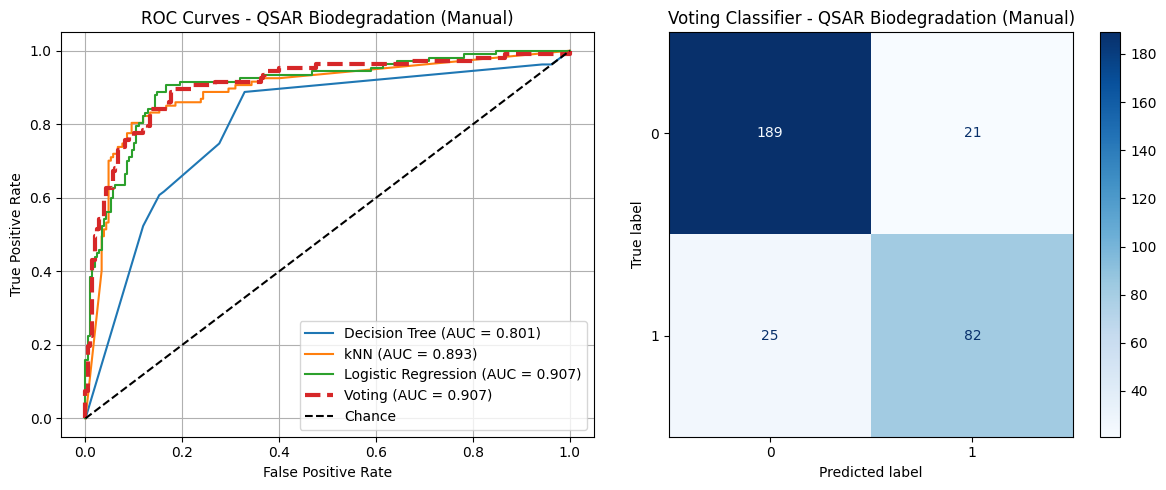

------------------------------

--- Running Built-in Grid Search for QSAR Biodegradation ---
Built-in search for LogisticRegression...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best params for LogisticRegression: {'classifier__C': 10, 'classifier__solver': 'liblinear'}
Best ROC AUC: 0.9369
Built-in search for SVC...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best params for SVC: {'classifier__C': 10, 'classifier__kernel': 'rbf'}
Best ROC AUC: 0.9338
Built-in search for RandomForestClassifier...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best params for RandomForestClassifier: {'classifier__max_depth': None, 'classifier__n_estimators': 50}
Best ROC AUC: 0.9282

EVALUATING BUILT-IN MODELS FOR QSAR BIODEGRADATION

--- Individual Model Performance ---

LogisticRegression:
  Accuracy: 0.8675
  Precision: 0.8351
  Recall: 0.7570
  F1-Score: 0.7941
  ROC AUC: 0.9038

SVC:
  Accuracy: 0.8833
  Precision: 0.8500
  Recall: 0.7944
  F1-Score: 0.

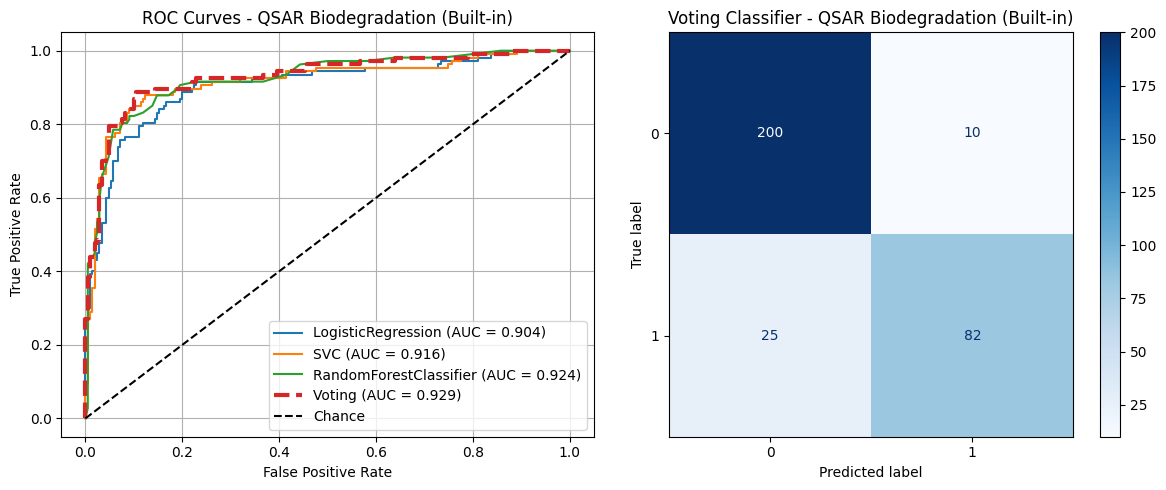


Completed processing for QSAR Biodegradation

ALL DATASETS PROCESSED!


In [34]:
# --- Run Pipeline for All Datasets ---
datasets = [
    (load_wine_quality, "Wine Quality"),
    (load_hr_attrition, "HR Attrition"),
    (load_banknote, "Banknote Authentication"),
    (load_qsar_biodegradation, "QSAR Biodegradation")
]

# Run for each dataset
for dataset_loader, dataset_name in datasets:
    try:
        run_complete_pipeline(dataset_loader, dataset_name)
    except Exception as e:
        print(f"Error processing {dataset_name}: {e}")
        continue

print("\n" + "="*80)
print("ALL DATASETS PROCESSED!")
print("="*80)